* nodes (developers): 49
* edges (relations): 49
* ranks based on count:
defaultdict(<class 'int'>, {'5b0fc400065f39020b8de36a': 1, '58bfca5b02ca40f8bf1479d4': 2, '58bfcbc902ca40f8bf147b05': 3, '5b0fc400065f3902048de36a': 4, '5b0fc400065f3902058de36a': 5, '5b0fc400065f3902068de37d': 6, '5967577254062d3debaf2655': 7, '5b0fc41a065f3902078dfb34': 8, '5b0fc41a065f39020e8dfa4c': 9, '5b0fc413065f3902128df4d2': 10, '5b0fc406065f39020a8de6cb': 11, '5b0fc41e065f3902118dfec0': 12, '5b0fc400065f39020f8de369': 13, '58bfcc0b02ca40f8bf147cc3': 14, '5b0fc400065f3902028de380': 15, '5b0fc406065f3902128de736': 16, '5b0fc419065f3902098dfa56': 17, '5b0fc401065f3902088de3ab': 18, '58bfcfde02ca40f8bf148139': 19, '5b0fc401065f3902088de3aa': 20, '5b0fc41f065f39020d8dff7b': 21, '5b0fc400065f3902098de369': 22, '5b0fc415065f39020f8df682': 23, '5b0fc41d065f39020a8dfb82': 24, '5b0fc402065f3902018de4c5': 25, '5b0fc421065f39020f8e01ed': 26, '5b0fc400065f39020b8de369': 27, '5b0fc415065f3902118df47b': 28, '5b0fc41c065

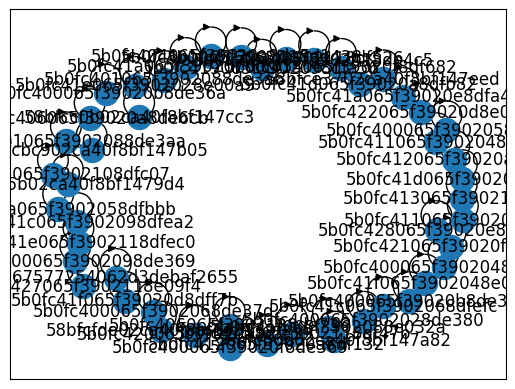

In [23]:
import rbo
import pickle
import numpy as np
import pandas as pd
import networkx as nx
from pathlib import Path
from pymongo import MongoClient
from mc4.algorithm import mc4_aggregator
from collections import Counter, defaultdict
import os

METAPATH_DIR = "D:\IIIT-A Course Works\stqm\metapaths.pkl"
GRAPH_DIR = "D:\IIIT-A Course Works\stqm\graph.pkl"
RANK_DIR = "D:\IIIT-A Course Works\stqm\gen_ranks.csv"

def get_metapaths():
    if os.path.exists(METAPATH_DIR):
        with open(METAPATH_DIR, "rb") as file:
            metapaths = pickle.load(file)
        return metapaths

    client = MongoClient("mongodb://localhost:27017")
    db = client["smartshark"]
    collection = db["commit_with_project_info"]
    cursor = collection.aggregate(
        [
            {
                "$match": {
                    "project_name_info.name": "kafka",
                }
            },
            {
                "$lookup": {
                    "from": "file_action",
                    "localField": "_id",
                    "foreignField": "commit_id",
                    "as": "join",
                }
            },
            {
                "$unwind": "$join",
            },
            {
                "$lookup": {
                    "from": "commit_with_project_info",
                    "localField": "join.commit_id",
                    "foreignField": "_id",
                    "as": "join2",
                }
            },
            {
                "$unwind": "$join2",
            },
            {
                "$match": {
                    "join2.project_name_info.name": "kafka",
                }
            },
            {
                "$project": {
                    "dev1": "$committer_id",
                    "file_id": "$join.file_id",
                    "dev2": "$join2.committer_id",
                }
            },
            {
                "$match": {
                    "dev1": {"$exists": "true"},
                    "file_id": {"$exists": "true"},
                    "dev2": {"$exists": "true"},
                }
            },
        ]
    )
    metapaths = []
    for doc in cursor:
        metapaths.append(
            {
                "developer1": str(doc["dev1"]),
                "file": str(doc["file_id"]),
                "developer2": str(doc["dev2"]),
            }
        )
    with open(METAPATH_DIR, "wb") as file:
        pickle.dump(metapaths, file)

    return metapaths


def create_graph(metapaths):
    if os.path.exists(GRAPH_DIR):
        with open(GRAPH_DIR, "rb") as file:
            G = pickle.load(file)
        return G
    G = nx.DiGraph()
    # get developer1 as keys
    keys = list(metapaths[0].keys())
    for path in metapaths:
        G.add_edge(path[keys[-1]], path[keys[0]])
    with open(GRAPH_DIR, "wb") as file:
        pickle.dump(G, file)
    return G


def rank_count_based(metapaths):
    count = Counter()
    ranks1 = defaultdict(int)
    keys = list(metapaths[0].keys())
    for path in metapaths:
        count[path[keys[0]]] += 1
    for i, (key, val) in enumerate(count.most_common()):
        ranks1[key] = i + 1
    return ranks1


def construct_ranks(metapaths, dic, ranks_hrank):
    keys = list(metapaths[0].keys())
    vals = list(dic[keys[0]])
    ranks_unsorted = defaultdict(int)
    for i in range(len(ranks_hrank)):
        ranks_unsorted[vals[i]] = ranks_hrank[i]
    ranks_sorted = sorted(ranks_unsorted.items(), key=lambda kv: kv[1], reverse=True)
    ranks_final = defaultdict(int)
    for i, (key, val) in enumerate(ranks_sorted):
        ranks_final[key] = i + 1
    return ranks_final


def rb_method_score(ranks1, ranks2):
    ranks1_keys = list(ranks1.keys())
    ranks2_keys = list(ranks2.keys())
    score = rbo.RankingSimilarity(ranks1_keys, ranks2_keys).rbo()
    return score


def get_reversed_metapaths(metapaths):
    # P_inv = (Al A(l-1) ... A1 | C)
    metapaths_rev = []
    for dic in metapaths:
        metapaths_rev.append(dict(reversed(list(dic.items()))))
    return metapaths_rev


def get_transition_probability_matrix(metapaths):
    is_path = defaultdict(lambda: defaultdict(int))
    dic = defaultdict(set)
    for i, path in enumerate(metapaths):
        keys, vals = list(path.keys()), list(path.values())
        for i in range(len(keys) - 1):
            is_path[vals[i]][vals[i + 1]] = 1
            dic[keys[i]].add(vals[i])
        dic[keys[-1]].add(vals[-1])
    # Adjacency Matrix (W)
    W = []
    keys, vals = list(dic.keys()), list(dic.values())
    for i in range(len(keys) - 1):
        A1, A2 = keys[i], keys[i + 1]
        len1, len2 = len(vals[i]), len(vals[i + 1])
        adj = np.zeros((len1, len2))
        for j, x1 in enumerate(vals[i]):
            for k, x2 in enumerate(vals[i + 1]):
                adj[j][k] = is_path[x1][x2]
        W.append(adj)
    # Transition Probability Matrix (U = W / |W|)
    for i, w in enumerate(W):
        row_sums = w.sum(axis=1)[:, None]
        for j, sum_ in enumerate(row_sums):
            if sum_ > 0:
                W[i][j] /= sum_
    return W, dic


def get_Mp(metapaths, U):
    # Constraint Matrix (Mc)
    # Mc = np.zeros((U[0].shape[0], U[0].shape[0]))
    # Mc[idx][idx] = 1
    # Constrained TPM (U' = Mc * U)
    # U_prime = Mc @ U[0];
    # Constrained metapath-based reachable probability matrix (Mp = multiply(U'))
    Mp = U[0]
    for i in range(1, len(U)):
        Mp = Mp @ U[i]
    row_sums = Mp.sum(axis=1)[:, None]
    for i, sum_ in enumerate(row_sums):
        if sum_ > 0:
            Mp[i] /= sum_
    return Mp


def hrank_SY(Mp, alpha, n_iter):
    # P = (A1 A2 ... Al | C)
    # E = 1 / |A1|
    # R(A1 | P) = α * R(A1 |P) * Mp + (1 − α) * E
    length = len(Mp)
    rank = np.zeros(length) + 1 / length
    for i in range(n_iter):
        rank = alpha * rank @ Mp + (1 - alpha) / length
    return rank


def hrank_AS(Mp, Mp_inv, alpha, n_iter):
    # E1 = 1 / |A1|
    # E2 = 1 / |A2|
    # R_inv(A1 | P_inv) = α * R(A1 |P) * Mp + (1 − α) * E2
    # R(A1 | P) = α * R_inv(A1 |P_inv) * Mp_inv + (1 − α) * E1
    length1 = len(Mp)
    length2 = len(Mp_inv)
    rank = np.zeros(length1) + 1 / length1
    rank_inv = np.zeros(length2) + 1 / length2
    for i in range(n_iter):
        rank_inv = alpha * rank @ Mp + (1 - alpha) / length2
        rank = alpha * rank_inv @ Mp_inv + (1 - alpha) / length1
    return rank, rank_inv


def main():
    metapaths = get_metapaths()
    graph = create_graph(metapaths)
    nx.draw_networkx(graph)
    # plt.show()
    print(f"* nodes (developers): {len(graph.nodes)}")
    print(f"* edges (relations): {len(graph.edges)}")
    ranks1 = rank_count_based(metapaths)
    print("* ranks based on count:")
    print(ranks1)

    ## HRank Symmetric
    U, dic = get_transition_probability_matrix(metapaths)
    Mp = get_Mp(metapaths, U)
    # alpha = 0.85
    # n_iter = 40
    # ranks_hrank = hrank_SY(Mp, alpha, n_iter)
    # ranks2 = construct_ranks(metapaths, dic, ranks_hrank)
    # print("\n* ranks based on HRank (SY):")
    # print(ranks2)

    ## HRank Asymmetric
    metapaths_rev = get_reversed_metapaths(metapaths)
    U, dic = get_transition_probability_matrix(metapaths_rev)
    Mp_inv = get_Mp(metapaths_rev, U)
    alpha = 0.85
    n_iter = 20
    ranks_hrank, _ = hrank_AS(Mp, Mp_inv, alpha, n_iter)
    # print(ranks_hrank)
    ranks3 = construct_ranks(metapaths, dic, ranks_hrank)
    print("\n* ranks based on HRank (AS):")
    print(ranks3)

    ## Save to dataframe
    df = pd.DataFrame([ranks3, ranks1], index=["hrank_AS", "count"])
    df.to_csv(RANK_DIR)

    ## RB score
    score = rb_method_score(ranks1, ranks3)
    print(f"\n* rb method score: {score}")

    # Rank aggregation
    ranks_agg = mc4_aggregator(str(RANK_DIR), order="column", header_row=0, index_col=0)
    # print(ranks_agg)

    ## Save to dataframe
    df = pd.DataFrame([ranks_agg, ranks3, ranks1], index=["ranks_aggregated", "hrank_AS", "count"])
    df.to_csv(RANK_DIR)


if __name__ == "__main__":
    main()
